<a href="https://colab.research.google.com/github/cmc6720/Bioplastics/blob/main/code/Transmission_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Input and Setup

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from numpy.linalg import inv
from numpy import *
import math
import scipy
from scipy.optimize import nnls
import sklearn
from sklearn.metrics import r2_score

In [ ]:
transmissionData = pd.read_csv("https://github.com/cmc6720/Bioplastics/blob/e8b9ca6a89aafa77a0837a24b3ce742a9bdf8438/Data/20210707transmissionData.csv?raw=true") 
summaryData = pd.read_csv("https://github.com/cmc6720/Bioplastics/blob/e08219928d188de41f85820b8c2496114f3c62fd/Data/BioplasticsResultSummaryABC.csv?raw=true")
#summaryDataPivot = summaryData.T
#summaryDataPivot
summaryData

,Unnamed: 0,A-SS,A-MC,A-DS,A-2SS-1MC,A-2MC-1SS,A-2SS-1DS,A-2DS-1SS,A-1SS-1MC-1DS,Unnamed: 9,B-SS,B-MC,B-DS,B-2SS-1MC,B-2MC-1SS,B-2SS-1DS,B-2DS-1SS,B-1SS-1MC-1DS,Unnamed: 18,C-SS,C-MC,C-DS,C-2SS-1MC,C-2MC-1SS,C-2SS-1DS,C-2DS-1SS,C-1SS-1MC-1DS
0,Desired starting wt to Area ratio (g/cm^2),60/80,60/80,60/80,60/80,60/80,60/80,60/80,60/80,NaN,20/80,20/80,20/80,20/80,20/80,20/80,20/80,20/80,NaN,20/80,20/80,20/80,20/80,20/80,20/80,20/80,20/80
1,Sargassum (g),1.81,NaN,NaN,1.23,0.61,1.23,0.6,0.79,NaN,0.61,NaN,NaN,0.4,0.2,0.38,0.2,0.26,NaN,0.59,NaN,NaN,0.43,0.2,0.4,0.2,0.28
2,MCC (g),0.59,2.42,0.63,1.2,1.82,0.67,0.61,0.82,NaN,0.2,0.84,0.22,0.4,0.6,0.2,0.21,0.26,NaN,0.2,0.84,0.2,0.43,0.59,0.2,0.2,0.27
3,Dulse (g),NaN,NaN,1.83,NaN,NaN,0.73,1.22,0.82,NaN,NaN,NaN,0.61,NaN,NaN,0.22,0.45,0.26,NaN,NaN,NaN,0.63,NaN,NaN,0.2,0.41,0.27
4,TFA (g),77.35,78,77.7,77.6,77.3,78,77.6,77.9,NaN,25.85,25.95,25.9,25.89,25.95,25.9,25.8,25.87,NaN,28.5,25.7,26.6,25.9,26.4,25.6,26,25.6
5,Shaker start date,29-May,29-May,29-May,29-May,29-May,29-May,29-May,29-May,NaN,3-Jun,3-Jun,3-Jun,3-Jun,3-Jun,3-Jun,3-Jun,3-Jun,NaN,30-Jun,30-Jun,30-Jun,30-Jun,30-Jun,30-Jun,30-Jun,30-Jun
6,Centrifuge start date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Casting date,2-Jun,2-Jun,2-Jun,2-Jun,2-Jun,2-Jun,2-Jun,2-Jun,NaN,6-Jun,6-Jun,6-Jun,6-Jun,6-Jun,6-Jun,6-Jun,6-Jun,NaN,4-Jul,4-Jul,4-Jul,4-Jul,4-Jul,4-Jul,4-Jul,4-Jul
8,Casting weight,60.1,look up,71.27,56.08,65.3,64.89,51.39,67.25,NaN,17.57,19.76,20.97,20.62,18.44,24.36,21.9,20.59,NaN,18.06,11.82,21.5,9.74,18.47,17,15.42,22.01
9,Petri removal date,3-Jun,3-Jun,3-Jun,3-Jun,3-Jun,3-Jun,3-Jun,3-Jun,NaN,7-Jun,7-Jun,7-Jun,7-Jun,7-Jun,7-Jun,7-Jun,7-Jun,NaN,7-Jul,7-Jul,7-Jul,7-Jul,7-Jul,7-Jul,7-Jul,7-Jul


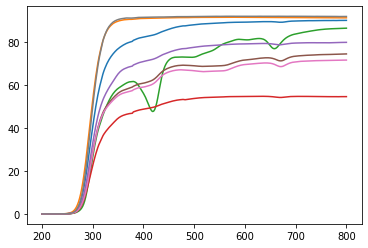

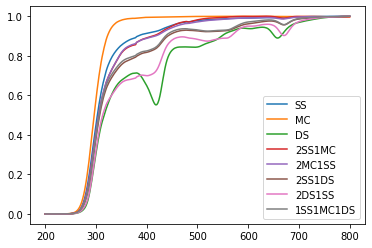

In [ ]:
fig, ax = plt.subplots()
#ax.plot(transmissionData['Wavelength'], transmissionData['Air'])
#ax.plot(transmissionData['Wavelength'], transmissionData['Glass'])
ax.plot(transmissionData['Wavelength'], transmissionData['SS'], label='SS')
ax.plot(transmissionData['Wavelength'], transmissionData['MC'], Label='MC')
ax.plot(transmissionData['Wavelength'], transmissionData['DS'], label='DS')
ax.plot(transmissionData['Wavelength'], transmissionData['2SS1MC'], label='2SS1MC')
ax.plot(transmissionData['Wavelength'], transmissionData['2MC1SS'], label='2MC1SS')
ax.plot(transmissionData['Wavelength'], transmissionData['2SS1DS'], label='2SS1DS')
#ax.plot(transmissionData['Wavelength'], transmissionData['2DS1SS'], label='2DS1SS')
ax.plot(transmissionData['Wavelength'], transmissionData['1SS1MC1DS'], label='1SS1MC1DS')
ax.plot(transmissionData['Wavelength'], transmissionData['Glass'])

#ax.legend()

fig, ax = plt.subplots()
#ax.plot(transmissionData['Wavelength'], transmissionData['Air'])
#ax.plot(transmissionData['Wavelength'], transmissionData['Glass'])
ax.plot(transmissionData['Wavelength'], transmissionData['SS']/max(transmissionData['SS']), label='SS')
ax.plot(transmissionData['Wavelength'], transmissionData['MC']/max(transmissionData['MC']), Label='MC')
ax.plot(transmissionData['Wavelength'], transmissionData['DS']/max(transmissionData['DS']), label='DS')
ax.plot(transmissionData['Wavelength'], transmissionData['2SS1MC']/max(transmissionData['2SS1MC']), label='2SS1MC')
ax.plot(transmissionData['Wavelength'], transmissionData['2MC1SS']/max(transmissionData['2MC1SS']), label='2MC1SS')
ax.plot(transmissionData['Wavelength'], transmissionData['2SS1DS']/max(transmissionData['2SS1DS']), label='2SS1DS')
ax.plot(transmissionData['Wavelength'], transmissionData['2DS1SS']/max(transmissionData['2DS1SS']), label='2DS1SS')
ax.plot(transmissionData['Wavelength'], transmissionData['1SS1MC1DS']/max(transmissionData['1SS1MC1DS']), label='1SS1MC1DS')
ax.legend()

# Define bioplastic class

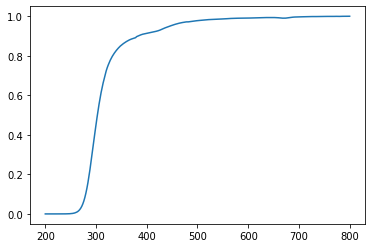

In [ ]:
class bioplastic:

  def __init__(self, name, transmission, summary, absorption=[], norm=False, normFactor=1):
    self.name = name
    self.transmission = np.nan_to_num(transmission)#.dropna()
    if (summary.size > 5):
      self.SS = np.nan_to_num(summary[1]).astype(np.float)
      self.MC = np.nan_to_num(summary[2]).astype(np.float)
      self.DS = np.nan_to_num(summary[3]).astype(np.float)
      try: 
        self.increaseInWeightAvg = np.nan_to_num(summary[23]).astype(np.float)
        self.increaseInWeightSTD = np.nan_to_num(summary[24]).astype(np.float)
        self.solubleWeightLostAvg = np.nan_to_num(summary[25]).astype(np.float)
        self.solubleWeightLostSTD = np.nan_to_num(summary[26]).astype(np.float)
        #print('Contains soluble data')
      except:
        print('Missing soluble data')
    else: 
      self.SS = np.nan_to_num(summary[0]).astype(np.float)
      self.MC = np.nan_to_num(summary[1]).astype(np.float)
      self.DS = np.nan_to_num(summary[2]).astype(np.float)
    if (len(absorption)>1):
      self.increaseInWeightAvg = absorption[0]
      self.increaseInWeightSTD = 0
      self.solubleWeightLostAvg = absorption[1]
      self.solubleWeightLostSTD = 0
    self.normFactor = 1/max(self.transmission)

  def plotTransmittance(self, ax, linetype='-', norm=False):
    if norm:
      ax.plot(transmissionData['Wavelength'], self.transmission*self.normFactor, linetype, label=self.name)
    else:
      ax.plot(transmissionData['Wavelength'], self.transmission, linetype, label=self.name)
  def getIngredientRatio(self):
    totalWt = sum([self.SS, self.MC, self.DS])
    return [self.SS/totalWt, self.MC/totalWt, self.DS/totalWt]
  def getIncreaseInWeight(self):
    return [self.increaseInWeightAvg, self.increaseInWeightSTD]
  def getSolubleWeightLost(self):
    return [self.solubleWeightLostAvg, self.solubleWeightLostSTD]
  def getTransmittance(self, norm=False):
    if norm:
      return self.transmission*self.normFactor
    return self.transmission

#def compareTransmittance(bioplastics)
BSS = bioplastic('B-SS', transmissionData['SS'], summaryData['B-SS'])
fig, ax=plt.subplots()
BSS.plotTransmittance(ax, norm=True)

In [ ]:
BSS = bioplastic('B-SS', transmissionData['SS'], summaryData['B-SS'])
BMC = bioplastic('B-MC', transmissionData['MC'], summaryData['B-MC'])
BDS = bioplastic('B-DS', transmissionData['DS'], summaryData['B-DS'])
B2SS1MC = bioplastic('B-2SS1MC', transmissionData['2SS1MC'], summaryData['B-2SS-1MC'])
B2MC1SS = bioplastic('B-2MC1SS', transmissionData['2MC1SS'], summaryData['B-2MC-1SS'])
B2SS1DS = bioplastic('B-2SS1DS', transmissionData['2SS1DS'], summaryData['B-2SS-1DS'])
B2DS1SS = bioplastic('B-2DS1SS', transmissionData['2DS1SS'], summaryData['B-2DS-1SS'])
B1SS1MC1DS = bioplastic('B-1SS1MC1DS', transmissionData['1SS1MC1DS'], summaryData['B-1SS-1MC-1DS'])


# Helper Functions

In [ ]:
def printSummaryTransmittance(toMatch, bestMatch):
  R2transmittance = r2_score(toMatch.getTransmittance(), bestMatch.getTransmittance())
  R2ingredients = r2_score(toMatch.getIngredientRatio(), bestMatch.getIngredientRatio())
  print(color.BOLD + "To Match = {}".format(toMatch.name) + color.END)
  print(color.UNDERLINE + "Ingredient results [Predicted (Actual)]" + color.END)
  print("Sargassum Percentage: {:.02f} ({:.2f})".format(bestMatch.getIngredientRatio()[0], toMatch.getIngredientRatio()[0]))
  print("Cellulose Percentage: {:.02f} ({:.2f})".format(bestMatch.getIngredientRatio()[1], toMatch.getIngredientRatio()[1]))
  print("Dulse Percentage: {:.02f} ({:.2f})".format(bestMatch.getIngredientRatio()[2], toMatch.getIngredientRatio()[2]))

  print(color.UNDERLINE + "R Squared" + color.END)
  print("Transmittance: {:.5f}".format(R2transmittance))
  print("Ingredients: {:.5f}".format(R2ingredients))
  print(" ")
  return R2transmittance, R2ingredients

In [ ]:
def printSummaryAbsorption(toMatch, bestMatch):
  toMatchAbsorption = [toMatch.getIncreaseInWeight()[0], toMatch.getSolubleWeightLost()[0] ]
  bestMatchAbsorption = [bestMatch.getIncreaseInWeight()[0], bestMatch.getSolubleWeightLost()[0] ]
  R2absorption = r2_score(toMatchAbsorption, bestMatchAbsorption)
  R2ingredients = r2_score(toMatch.getIngredientRatio(), bestMatch.getIngredientRatio())
  print(color.BOLD + "To Match = {}".format(toMatch.name) + color.END)
  printSummaryIngredientsHelper(toMatch,bestMatch)
  print(color.UNDERLINE + "Absorption [Predicted (Actual)]" + color.END)
  print("Increase in Weight: {:.02f} ({:.2f})".format(bestMatchAbsorption[0], toMatchAbsorption[0]))
  print("Soluble Weight Lost: {:.02f} ({:.2f})".format(bestMatchAbsorption[1], toMatchAbsorption[1]))
  print(color.UNDERLINE + "R Squared" + color.END)
  print("Absorption: {:.5f}".format(R2absorption))
  print("Ingredients: {:.5f}".format(R2ingredients))
  print(" ")
  return R2absorption, R2ingredients


def printSummaryIngredientsHelper(toMatch,bestMatch):
  print(color.UNDERLINE + "Ingredient results [Predicted (Actual)]" + color.END)
  print("Sargassum Percentage: {:.02f} ({:.2f})".format(bestMatch.getIngredientRatio()[0], toMatch.getIngredientRatio()[0]))
  print("Cellulose Percentage: {:.02f} ({:.2f})".format(bestMatch.getIngredientRatio()[1], toMatch.getIngredientRatio()[1]))
  print("Dulse Percentage: {:.02f} ({:.2f})".format(bestMatch.getIngredientRatio()[2], toMatch.getIngredientRatio()[2]))

In [ ]:
def transmittanceIngredientsXY(toMatch,bioplastics):
  transmittance_y = toMatch.getTransmittance()
  ingredients_y = toMatch.getIngredientRatio()
  print(bioplastics)
  transmittance_x = np.zeros_like(bioplastics[0].getTransmittance())
  transmittance_x_real = np.zeros_like(bioplastics[0].getTransmittance())
  ingredients_x = np.zeros_like(bioplastics[0].getIngredientRatio())
  norms = []
  for bio in bioplastics: 
    transmittance_x = np.vstack((transmittance_x, bio.getTransmittance()))
    transmittance_x_real = np.vstack((transmittance_x, bio.getTransmittance())) #never normalized to compute 'real' results
    norms = np.append(norms, max(bio.getTransmittance()))
    ingredients_x = np.vstack((ingredients_x, bio.getIngredientRatio()))
  transmittance_x = np.delete(transmittance_x, (0), axis=0)
  transmittance_x_real = np.delete(transmittance_x_real, (0), axis=0)
  ingredients_x = np.delete(ingredients_x, (0), axis=0)
  return transmittance_x, transmittance_x_real, transmittance_y, ingredients_x, ingredients_y, norms
  #print(transmittance_x.shape[0])

In [ ]:
def absorptionIngredientsXY(toMatch,bioplastics):
  absorption_y = toMatch.getIncreaseInWeight() + toMatch.getSolubleWeightLost()
  ingredients_y = toMatch.getIngredientRatio()
  absorption_x = np.zeros_like(absorption_y)
  ingredients_x = np.zeros_like(bioplastics[0].getIngredientRatio())
  norms = []
  for bio in bioplastics: 
    temp_x = bio.getIncreaseInWeight() + bio.getSolubleWeightLost()
    absorption_x = np.vstack((absorption_x, temp_x))
    ingredients_x = np.vstack((ingredients_x, bio.getIngredientRatio()))
  absorption_x = np.delete(absorption_x, (0), axis=0)
  ingredients_x = np.delete(ingredients_x, (0), axis=0)
  return absorption_x, absorption_y, ingredients_x, ingredients_y


# Function: predictFromTransmittanceNNLS - Predict ingredients from transmittance NNLS

In [ ]:

def predictFromTransmittanceNNLS(bioplastics, toMatch, ax, norm=False):
  # Input: transmittance
  # Output: ingredient ratio
  # toMatch =bioplastic("To Match", toMatchTemp.getTransmittance(), toMatchTemp.SS, toMatchTemp.MC, toMatchTemp.])
  #transmittance_y = toMatch.getTransmittance(norm)
  #ingredients_y = toMatch.getIngredientRatio()

  #transmittance_x = np.zeros_like(bioplastics[0].getTransmittance(norm))
  #transmittance_x_real = np.zeros_like(bioplastics[0].getTransmittance(norm=False))
  #ingredients_x = np.zeros_like(bioplastics[0].getIngredientRatio())
  #for bio in bioplastics: 
  #  transmittance_x = np.vstack((transmittance_x, bio.getTransmittance(norm)))
  #  transmittance_x_real = np.vstack((transmittance_x, bio.getTransmittance(norm=False))) #never normalized to compute 'real' results
  #  ingredients_x = np.vstack((ingredients_x, bio.getIngredientRatio()))
  #transmittance_x = np.delete(transmittance_x, (0), axis=0)
  #transmittance_x_real = np.delete(transmittance_x_real, (0), axis=0)
  #ingredients_x = np.delete(ingredients_x, (0), axis=0)
  #print(transmittance_x.shape[0])
  transmittance_x, transmittance_x_real, transmittance_y, ingredients_x, ingredients_y, norms = transmittanceIngredientsXY(toMatch,bioplastics)

  # make sure results add to 1
  big_number = 100000
  transmittance_x = np.hstack((transmittance_x, big_number*np.ones((transmittance_x.shape[0],1))))
  transmittance_y = np.append(transmittance_y, big_number)
  #print(transmittance_x)

  # transpose
  transmittance_x = transmittance_x.T
  transmittance_x_real = transmittance_x_real.T
  ingredients_x = ingredients_x.T
  # least squares
  #x = np.matmul(np.matmul(np.linalg.inv(np.matmul(transmittance_x.T, transmittance_x)),transmittance_x.T), transmittance_y)

  # non-negative least squares
  [x,xx] = scipy.optimize.nnls(transmittance_x,transmittance_y)
  #disp(transmittance_x_real.shape)
  bestMatch_transmittance = matmul(transmittance_x[:-1, :], x)
  bestMatch_ingredients = matmul(ingredients_x, x)
  bestMatch = bioplastic('Best Match', bestMatch_transmittance, bestMatch_ingredients)

  #toMatchBioplastic = bioplastic('To Match', transmittance_y, ingredients_y)
  #fig, ax = plt.subplots()
  norm = False
  for bio in bioplastics:
    #if norm:
    bio.plotTransmittance(ax,'--', norm=norm)
    #else:
    #  bio.plotTransmittance(ax,'--')
  toMatch.plotTransmittance(ax, norm=norm)
  bestMatch.plotTransmittance(ax,norm=norm)
  ax.legend()
  ax.set_title('Transmittance-based prediction')
  R2transmittance = r2_score(toMatch.getTransmittance(), bestMatch.getTransmittance())
  R2ingredients = r2_score(toMatch.getIngredientRatio(), bestMatch.getIngredientRatio())
  print(color.BOLD + "To Match = {}".format(toMatch.name) + color.END)
  print(color.UNDERLINE + "Ingredient results [Best Match (To Match)]" + color.END)
  print("Sargassum Percentage: {:.02f} ({:.2f})".format(bestMatch.getIngredientRatio()[0], toMatch.getIngredientRatio()[0]))
  print("Cellulose Percentage: {:.02f} ({:.2f})".format(bestMatch.getIngredientRatio()[1], toMatch.getIngredientRatio()[1]))
  print("Dulse Percentage: {:.02f} ({:.2f})".format(bestMatch.getIngredientRatio()[2], toMatch.getIngredientRatio()[2]))

  print(color.UNDERLINE + "R Squared" + color.END)
  print("Transmittance: {:.5f}".format(R2transmittance))
  print("Ingredients: {:.5f}".format(R2ingredients))
  print(" ")
  return [R2transmittance, R2ingredients]
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
def getBioplasticR2(toMatch, bestMatch, norm):
  R2transmittance = r2_score(toMatch.getTransmittance(), bestMatch.getTransmittance())
  R2ingredients = r2_score(toMatch.getIngredientRatio(), bestMatch.getIngredientRatio())
  print(color.BOLD + "To Match = {}".format(toMatch.name) + color.END)
  print(color.UNDERLINE + "Ingredient results [Best Match (To Match)]" + color.END)
  print("Sargassum Percentage: {:.02f} ({:.2f})".format(bestMatch.getIngredientRatio()[0], toMatch.getIngredientRatio()[0]))
  print("Cellulose Percentage: {:.02f} ({:.2f})".format(bestMatch.getIngredientRatio()[1], toMatch.getIngredientRatio()[1]))
  print("Dulse Percentage: {:.02f} ({:.2f})".format(bestMatch.getIngredientRatio()[2], toMatch.getIngredientRatio()[2]))

  print(color.UNDERLINE + "R Squared" + color.END)
  print("Transmittance: {:.5f}".format(R2transmittance))
  print("Ingredients: {:.5f}".format(R2ingredients))
  print(" ")


[<__main__.bioplastic object at 0x7f76467afed0>, <__main__.bioplastic object at 0x7f76467afa10>, <__main__.bioplastic object at 0x7f76467af4d0>, <__main__.bioplastic object at 0x7f76467af390>, <__main__.bioplastic object at 0x7f76467af850>, <__main__.bioplastic object at 0x7f76467af050>]
To Match = B-2SS1DS
Ingredient results [Best Match (To Match)]
Sargassum Percentage: 0.42 (0.47)
Cellulose Percentage: 0.34 (0.25)
Dulse Percentage: 0.24 (0.27)
R Squared
Transmittance: 0.99968
Ingredients: 0.62560
 


[0.9996760137006145, 0.6255954091491239]

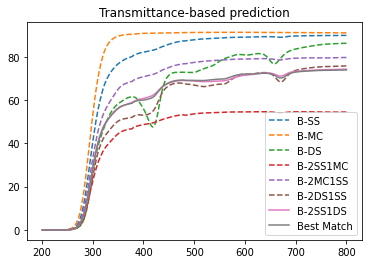

In [ ]:
bioplastics = [ BSS, BMC, BDS, B2SS1MC, B2MC1SS, B2DS1SS]

toMatch = B2SS1DS
fig, ax=plt.subplots()
predictFromTransmittanceNNLS(bioplastics, toMatch, ax, norm=False)

[<__main__.bioplastic object at 0x7f76467afa10>, <__main__.bioplastic object at 0x7f76467af4d0>, <__main__.bioplastic object at 0x7f76467af390>, <__main__.bioplastic object at 0x7f76467af850>, <__main__.bioplastic object at 0x7f76467af350>, <__main__.bioplastic object at 0x7f76467af050>, <__main__.bioplastic object at 0x7f76467af710>]
To Match = B-SS
Ingredient results [Best Match (To Match)]
Sargassum Percentage: 0.02 (0.75)
Cellulose Percentage: 0.80 (0.25)
Dulse Percentage: 0.19 (0.00)
R Squared
Transmittance: 0.99553
Ingredients: -1.99030
 
[<__main__.bioplastic object at 0x7f76467afed0>, <__main__.bioplastic object at 0x7f76467af4d0>, <__main__.bioplastic object at 0x7f76467af390>, <__main__.bioplastic object at 0x7f76467af850>, <__main__.bioplastic object at 0x7f76467af350>, <__main__.bioplastic object at 0x7f76467af050>, <__main__.bioplastic object at 0x7f76467af710>]
To Match = B-MC
Ingredient results [Best Match (To Match)]
Sargassum Percentage: 0.75 (0.00)
Cellulose Percentag

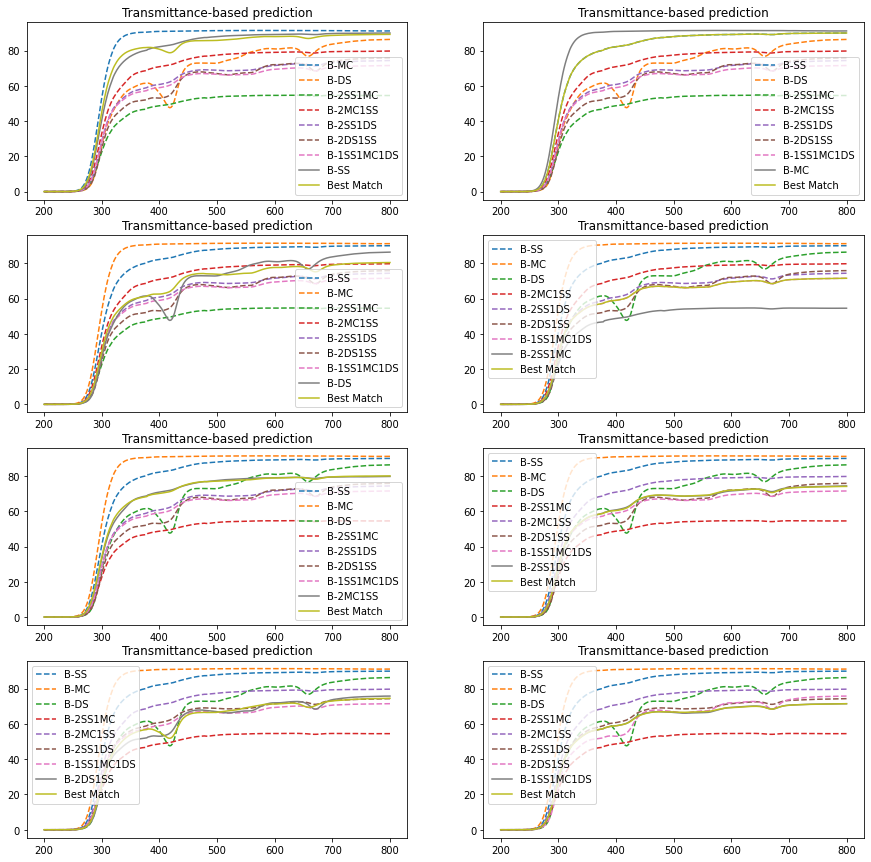

In [ ]:

allBioplastics = [BSS, BMC, BDS, B2SS1MC, B2MC1SS, B2SS1DS, B2DS1SS, B1SS1MC1DS]
#allBioplastics = [BSS, BMC, BDS, B2MC1SS, B2SS1DS, B2DS1SS, B1SS1MC1DS]

fig, ((ax1,ax2),(ax3,ax4), (ax5,ax6), (ax7,ax8)) = plt.subplots(4,2, figsize=(15,15))
axs = (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8)
r2T = np.zeros(8)
r2I = np.zeros(8)

for i, bioToMatch in enumerate(allBioplastics[:]):
  bioBioplastics = allBioplastics[:i] + allBioplastics[(i+1):]
  [r2T[i], r2I[i]] = predictFromTransmittanceNNLS(bioBioplastics, bioToMatch, axs[i])



[<__main__.bioplastic object at 0x7f76467afed0>, <__main__.bioplastic object at 0x7f76467afa10>, <__main__.bioplastic object at 0x7f76467af4d0>, <__main__.bioplastic object at 0x7f76467af390>]
To Match = B-2SS1MC
Ingredient results [Best Match (To Match)]
Sargassum Percentage: 0.50 (0.50)
Cellulose Percentage: 0.50 (0.50)
Dulse Percentage: 0.00 (0.00)
R Squared
Transmittance: 1.00000
Ingredients: 1.00000
 
[<__main__.bioplastic object at 0x7f76467afed0>, <__main__.bioplastic object at 0x7f76467afa10>, <__main__.bioplastic object at 0x7f76467af4d0>, <__main__.bioplastic object at 0x7f76467af390>]
To Match = B-2MC1SS
Ingredient results [Best Match (To Match)]
Sargassum Percentage: 0.61 (0.25)
Cellulose Percentage: 0.32 (0.75)
Dulse Percentage: 0.08 (0.00)
R Squared
Transmittance: 0.99936
Ingredients: -0.09351
 
[<__main__.bioplastic object at 0x7f76467afed0>, <__main__.bioplastic object at 0x7f76467afa10>, <__main__.bioplastic object at 0x7f76467af4d0>, <__main__.bioplastic object at 0x7

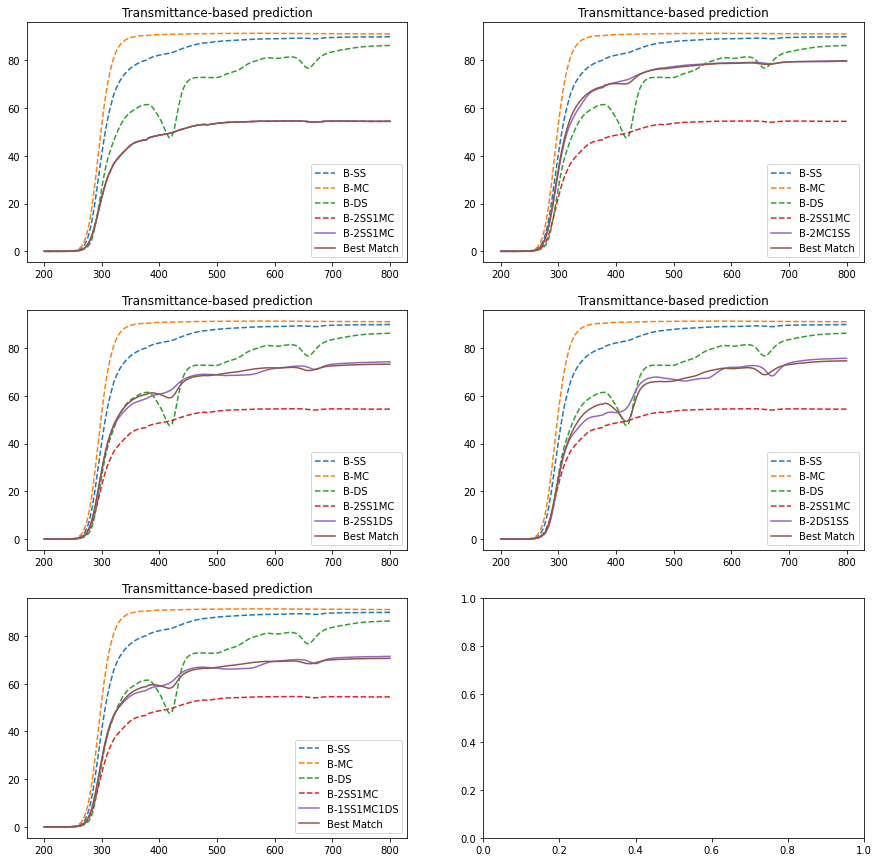

In [ ]:
knownBioplastics = [BSS, BMC, BDS, B2SS1MC]
unknownBioplastics = [B2SS1MC, B2MC1SS, B2SS1DS, B2DS1SS, B1SS1MC1DS]

fig, ((ax1,ax2),(ax3,ax4), (ax5,ax6)) = plt.subplots(3,2, figsize=(15,15))
axs = (ax1,ax2,ax3,ax4,ax5,ax6)

for i, bioToMatch in enumerate(unknownBioplastics[:]):
  predictFromTransmittanceNNLS(knownBioplastics, bioToMatch, axs[i])

# Function: predictFromTransmittanceNormNNLS

In [ ]:
def transmittanceIngredientsXYNorm(toMatch, bioplastics):
  transmittance_y_real = toMatch.getTransmittance()
  transmittance_y = transmittance_y_real/max(transmittance_y_real)
  ingredients_y = toMatch.getIngredientRatio()

  transmittance_x_real = np.zeros_like(bioplastics[0].getTransmittance())
  transmittance_x = np.zeros_like(bioplastics[0].getTransmittance())
  ingredients_x = np.zeros_like(bioplastics[0].getIngredientRatio())
  norms = []
  for bio in bioplastics: 
    transmittance_x = np.vstack((transmittance_x, bio.getTransmittance()/max(bio.getTransmittance())))
    norms = np.append(norms, max(bio.getTransmittance()))
    transmittance_x_real = np.vstack((transmittance_x, bio.getTransmittance())) #never normalized to compute 'real' results
    ingredients_x = np.vstack((ingredients_x, bio.getIngredientRatio()))
  transmittance_x = np.delete(transmittance_x, (0), axis=0)
  transmittance_x_real = np.delete(transmittance_x_real, (0), axis=0)
  ingredients_x = np.delete(ingredients_x, (0), axis=0)
  #print(transmittance_x.shape[0])
  return transmittance_x, transmittance_x_real, transmittance_y, ingredients_x, ingredients_y, norms

def predictFromTransmittanceNormNNLS(bioplastics, toMatch, ax, norm=False):
  # Input: transmittance
  # Output: ingredient ratio
  # toMatch =bioplastic("To Match", toMatchTemp.getTransmittance(), toMatchTemp.SS, toMatchTemp.MC, toMatchTemp.])
  
  transmittance_x, transmittance_x_real, transmittance_y, ingredients_x, ingredients_y, norms = transmittanceIngredientsXYNorm(toMatch, bioplastics)
  print(norms)
  # make sure results add to 1
  big_number = 100000
  transmittance_x = np.hstack((transmittance_x, big_number*np.ones((transmittance_x.shape[0],1))))
  transmittance_y = np.append(transmittance_y, big_number)
  #print(transmittance_x)

  # transpose
  transmittance_x = transmittance_x.T
  transmittance_x_real = transmittance_x_real.T
  ingredients_x = ingredients_x.T
  # least squares
  #x = np.matmul(np.matmul(np.linalg.inv(np.matmul(transmittance_x.T, transmittance_x)),transmittance_x.T), transmittance_y)

  # non-negative least squares
  [x,xx] = scipy.optimize.nnls(transmittance_x,transmittance_y)
  #disp(transmittance_x_real.shape)
  bestMatchNorms = zeros_like(x)
  
  for i in range(0, len(x)):
    bestMatchNorms[i] = x[i]*norms[i]
  
  bestMatch_transmittance = matmul(transmittance_x[:-1, :], bestMatchNorms)
  #bestMatch_transmittance = matmul(bestMatch_transmittance_temp, bestMatchNorm.T)
  bestMatch_ingredients = matmul(ingredients_x, x)
  
  bestMatch = bioplastic('Best Match', bestMatch_transmittance, bestMatch_ingredients)

  #toMatchBioplastic = bioplastic('To Match', transmittance_y, ingredients_y)
  #fig, ax = plt.subplots()
  norm = False
  for bio in bioplastics:
    #if norm:
    bio.plotTransmittance(ax,'--', norm=norm)
    #else:
    #  bio.plotTransmittance(ax,'--')
  toMatch.plotTransmittance(ax, norm=norm)
  bestMatch.plotTransmittance(ax,norm=norm)
  ax.legend()
  ax.set_title('Normalized Transmittance-based prediction')
  R2transmittance = r2_score(toMatch.getTransmittance(), bestMatch.getTransmittance())
  R2ingredients = r2_score(toMatch.getIngredientRatio(), bestMatch.getIngredientRatio())
  print(color.BOLD + "To Match = {}".format(toMatch.name) + color.END)
  print(color.UNDERLINE + "Ingredient results [Best Match (To Match)]" + color.END)
  print("Sargassum Percentage: {:.02f} ({:.2f})".format(bestMatch.getIngredientRatio()[0], toMatch.getIngredientRatio()[0]))
  print("Cellulose Percentage: {:.02f} ({:.2f})".format(bestMatch.getIngredientRatio()[1], toMatch.getIngredientRatio()[1]))
  print("Dulse Percentage: {:.02f} ({:.2f})".format(bestMatch.getIngredientRatio()[2], toMatch.getIngredientRatio()[2]))

  print(color.UNDERLINE + "R Squared" + color.END)
  print("Transmittance: {:.5f}".format(R2transmittance))
  print("Ingredients: {:.5f}".format(R2ingredients))
  print(" ")
  return [R2transmittance, R2ingredients]

[91.400776 86.316561 54.650373 79.733733 74.350557 75.821323 71.501665]
To Match = B-SS
Ingredient results [Best Match (To Match)]
Sargassum Percentage: 0.22 (0.75)
Cellulose Percentage: 0.77 (0.25)
Dulse Percentage: 0.02 (0.00)
R Squared
Transmittance: 0.93165
Ingredients: -0.90056
 
[89.949866 86.316561 54.650373 79.733733 74.350557 75.821323 71.501665]
To Match = B-MC
Ingredient results [Best Match (To Match)]
Sargassum Percentage: 0.75 (0.00)
Cellulose Percentage: 0.25 (1.00)
Dulse Percentage: 0.00 (0.00)
R Squared
Transmittance: 0.96228
Ingredients: -0.70142
 
[89.949866 91.400776 54.650373 79.733733 74.350557 75.821323 71.501665]
To Match = B-DS
Ingredient results [Best Match (To Match)]
Sargassum Percentage: 0.23 (0.00)
Cellulose Percentage: 0.24 (0.27)
Dulse Percentage: 0.52 (0.73)
R Squared
Transmittance: 0.92915
Ingredients: 0.64149
 
[89.949866 91.400776 86.316561 79.733733 74.350557 75.821323 71.501665]
To Match = B-2SS1MC
Ingredient results [Best Match (To Match)]
Sargassu

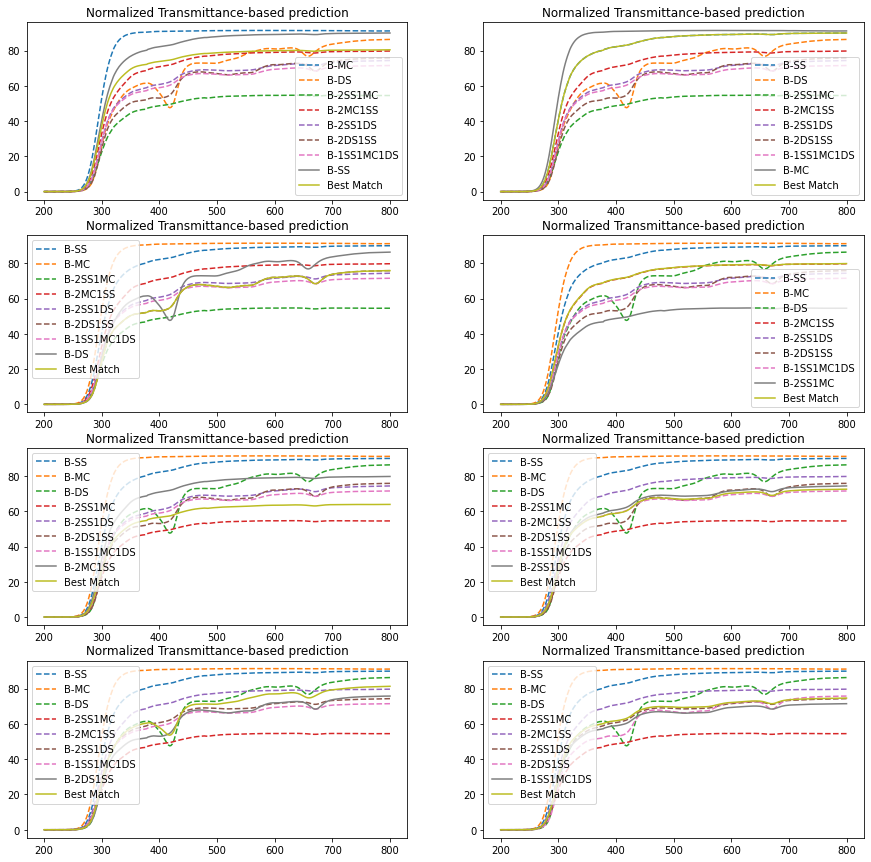

In [ ]:
allBioplastics = [BSS, BMC, BDS, B2SS1MC, B2MC1SS, B2SS1DS, B2DS1SS, B1SS1MC1DS]

fig, ((ax1,ax2),(ax3,ax4), (ax5,ax6), (ax7,ax8)) = plt.subplots(4,2, figsize=(15,15))
axs = (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8)
r2T = np.zeros(8)
r2I = np.zeros(8)

for i, bioToMatch in enumerate(allBioplastics[:]):
  bioBioplastics = allBioplastics[:i] + allBioplastics[(i+1):]
  [r2T[i], r2I[i]] = predictFromTransmittanceNormNNLS(bioBioplastics, bioToMatch, axs[i])
disp(average(r2T))
disp(average(r2I))

# Function: predictFromIngredientsNNLS - Predict transmittance from ingredients NNLS 


In [ ]:
def predictFromIngredientsNNLS(bioplastics, toMatch, ax, norm=False):
  # Input: ingredient ratio
  # Output: transmittance
  # toMatch =bioplastic("To Match", toMatchTemp.getTransmittance(), toMatchTemp.SS, toMatchTemp.MC, toMatchTemp.])

  transmittance_x, transmittance_x_real, transmittance_y, ingredients_x, ingredients_y, norms = transmittanceIngredientsXY(toMatch,bioplastics)

  # make sure results add to 1
  big_number = 100000
  ingredients_x = np.hstack((ingredients_x, big_number*np.ones((ingredients_x.shape[0],1))))
  ingredients_y = np.append(ingredients_y, big_number)
  #print(transmittance_x)

  # transpose
  transmittance_x = transmittance_x.T
  #transmittance_x_real = transmittance_x_real.T
  ingredients_x = ingredients_x.T
  # least squares
  #x = np.matmul(np.matmul(np.linalg.inv(np.matmul(transmittance_x.T, transmittance_x)),transmittance_x.T), transmittance_y)

  # non-negative least squares
  [x,xx] = scipy.optimize.nnls(ingredients_x, ingredients_y)
  #disp(transmittance_x_real.shape)
  bestMatch_transmittance = matmul(transmittance_x[:, :], x)
  bestMatch_ingredients = matmul(ingredients_x[:-1,:], x)
  bestMatch = bioplastic('Best Match', bestMatch_transmittance, bestMatch_ingredients)

  #toMatchBioplastic = bioplastic('To Match', transmittance_y, ingredients_y)
  #fig, ax = plt.subplots()
  norm = False
  # for bio in bioplastics:
    #if norm:
    #  bio.plotTransmittance(ax,'--', norm=norm)
    #else:
    #  bio.plotTransmittance(ax,'--')
  # toMatch.plotTransmittance(ax, norm=norm)
  ax.plot(transmissionData['Wavelength'], toMatch.getTransmittance(), label='Actual', color=mcolors.CSS4_COLORS['firebrick'])
  ax.plot(transmissionData['Wavelength'], bestMatch.getTransmittance(), label='Predicted', color=mcolors.CSS4_COLORS['darkorange'])

  # bestMatch.plotTransmittance(ax,norm=norm)
  ax.legend()
  ax.set_title('Ingredient-based prediction')
  #plt.title('Ingredient-based prediction')
  #ax.title('Transmittance predicted from Ingredients NNLS')
  R2transmittance, R2ingredients = printSummaryTransmittance(toMatch, bestMatch)


[<__main__.bioplastic object at 0x7f76467afa10>, <__main__.bioplastic object at 0x7f76467af4d0>, <__main__.bioplastic object at 0x7f76467af390>, <__main__.bioplastic object at 0x7f76467af850>, <__main__.bioplastic object at 0x7f76467af350>, <__main__.bioplastic object at 0x7f76467af050>, <__main__.bioplastic object at 0x7f76467af710>]
To Match = B-SS
Ingredient results [Predicted (Actual)]
Sargassum Percentage: 0.49 (0.75)
Cellulose Percentage: 0.40 (0.25)
Dulse Percentage: 0.11 (0.00)
R Squared
Transmittance: 0.34092
Ingredients: 0.64469
 
[<__main__.bioplastic object at 0x7f76467afed0>, <__main__.bioplastic object at 0x7f76467af4d0>, <__main__.bioplastic object at 0x7f76467af390>, <__main__.bioplastic object at 0x7f76467af850>, <__main__.bioplastic object at 0x7f76467af350>, <__main__.bioplastic object at 0x7f76467af050>, <__main__.bioplastic object at 0x7f76467af710>]
To Match = B-MC
Ingredient results [Predicted (Actual)]
Sargassum Percentage: 0.25 (0.00)
Cellulose Percentage: 0.75

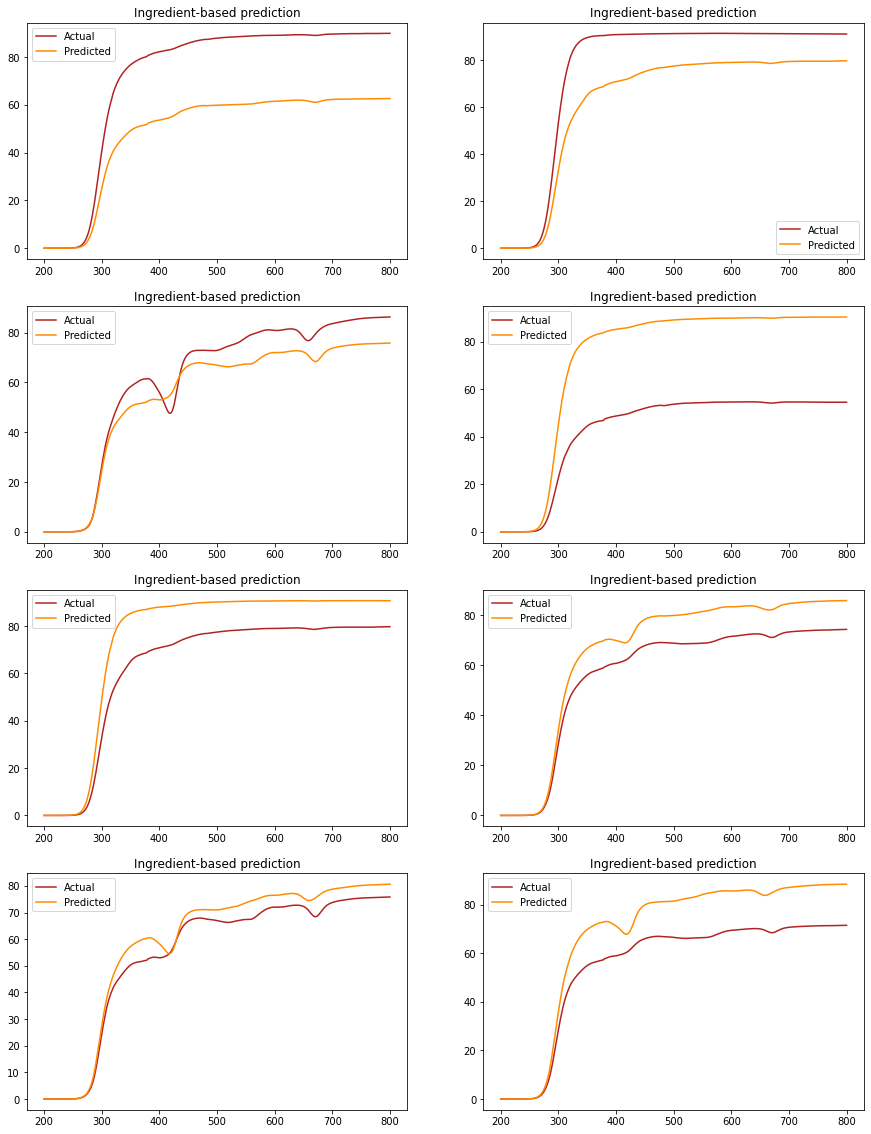

In [ ]:
import matplotlib.colors as mcolors
allBioplastics = [BSS, BMC, BDS, B2SS1MC, B2MC1SS, B2SS1DS, B2DS1SS, B1SS1MC1DS]

fig, ((ax1,ax2),(ax3,ax4), (ax5,ax6), (ax7,ax8)) = plt.subplots(4,2, figsize=(15,20))
axs = (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8)

for i, bioToMatch in enumerate(allBioplastics[:]):
  bioBioplastics = allBioplastics[:i] + allBioplastics[(i+1):]
  predictFromIngredientsNNLS(bioBioplastics, bioToMatch, axs[i])
  

# Function: predictNNLS - Combination of prediction Tranmittance/Ingredients NNLS

In [ ]:
def is_odd(num):
   return num % 2

def predictTransmissionNNLS(allBioplastics, type):
  # type = 0 - predict ingredients from transmittance (NNLS on transmittance matrix)
  # type = 1 - predict transmittance from ingredients (NNLS on ingredient matrix)
  fig, ((ax1,ax2),(ax3,ax4), (ax5,ax6), (ax7,ax8)) = plt.subplots(4,2, figsize=(15,15))
  axs = (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8)
  for i, bioToMatch in enumerate(allBioplastics[:]):
    bioBioplastics = allBioplastics[:i] + allBioplastics[(i+1):]
    if type==0:
      predictFromTransmittanceNNLS(bioBioplastics, bioToMatch, axs[i])
    if type==1:
      predictFromIngredientsNNLS(bioBioplastics, bioToMatch, axs[i])
    if type>1:
      print('Type should be 0 (predict ingredients from transmittance) or 1 (predict transmittance from ingredients)')
#  #allAxs = (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12,ax13,ax14,ax15,ax16,ax17,ax18,ax19,ax20)
#  fig, axsRearranged = plt.subplots(4,2, figsize=(15,15))
#  ii = len(allBioplastics)
#  if is_odd(ii):
#    ii = ii+1
#  axsRearranged = zeros((ii/2, 2))
#  for i in range(0,len(allBioplastics)):
#    axs = axs + allAxs[i]
#    if is_odd(i):
#      axsRearranged[1,(i-1)/2]
#    else: 
#     axsRearranged[1,i/2]


## Transmittance based prediction

[<__main__.bioplastic object at 0x7fe8d16cf650>, <__main__.bioplastic object at 0x7fe8d16cfc50>, <__main__.bioplastic object at 0x7fe8d16cffd0>, <__main__.bioplastic object at 0x7fe8d16cff10>, <__main__.bioplastic object at 0x7fe8d16cfa50>, <__main__.bioplastic object at 0x7fe8d1b68c50>, <__main__.bioplastic object at 0x7fe8d1b68a90>]
To Match = B-SS
Ingredient results [Best Match (To Match)]
Sargassum Percentage: 0.02 (0.75)
Cellulose Percentage: 0.80 (0.25)
Dulse Percentage: 0.19 (0.00)
R Squared
Transmittance: 0.99553
Ingredients: -1.99030
 
[<__main__.bioplastic object at 0x7fe8d16cfb10>, <__main__.bioplastic object at 0x7fe8d16cfc50>, <__main__.bioplastic object at 0x7fe8d16cffd0>, <__main__.bioplastic object at 0x7fe8d16cff10>, <__main__.bioplastic object at 0x7fe8d16cfa50>, <__main__.bioplastic object at 0x7fe8d1b68c50>, <__main__.bioplastic object at 0x7fe8d1b68a90>]
To Match = B-MC
Ingredient results [Best Match (To Match)]
Sargassum Percentage: 0.75 (0.00)
Cellulose Percentag

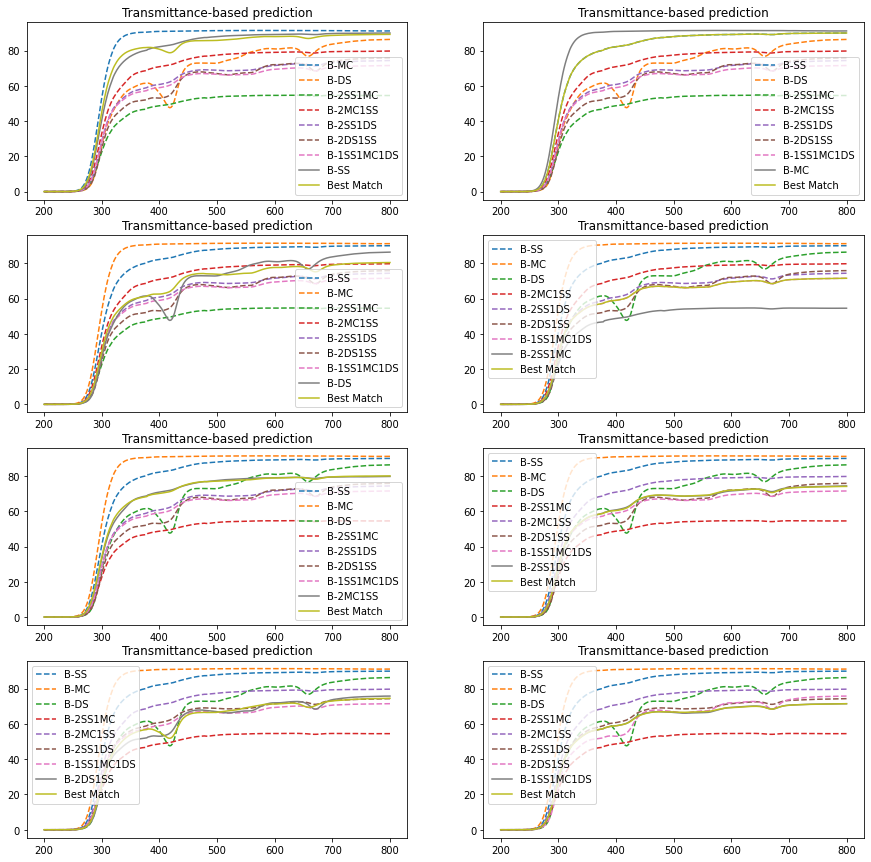

In [ ]:
# Transmittance based prediction
allBioplastics = [BSS, BMC, BDS, B2SS1MC, B2MC1SS, B2SS1DS, B2DS1SS, B1SS1MC1DS]
predictTransmissionNNLS(allBioplastics, 0)

## Ingredient based prediction

[<__main__.bioplastic object at 0x7fe8d16cf650>, <__main__.bioplastic object at 0x7fe8d16cfc50>, <__main__.bioplastic object at 0x7fe8d16cffd0>, <__main__.bioplastic object at 0x7fe8d16cff10>, <__main__.bioplastic object at 0x7fe8d16cfa50>, <__main__.bioplastic object at 0x7fe8d1b68c50>, <__main__.bioplastic object at 0x7fe8d1b68a90>]
To Match = B-SS
Ingredient results [Best Match (To Match)]
Sargassum Percentage: 0.49 (0.75)
Cellulose Percentage: 0.40 (0.25)
Dulse Percentage: 0.11 (0.00)
R Squared
Transmittance: 0.34092
Ingredients: 0.64469
 
[<__main__.bioplastic object at 0x7fe8d16cfb10>, <__main__.bioplastic object at 0x7fe8d16cfc50>, <__main__.bioplastic object at 0x7fe8d16cffd0>, <__main__.bioplastic object at 0x7fe8d16cff10>, <__main__.bioplastic object at 0x7fe8d16cfa50>, <__main__.bioplastic object at 0x7fe8d1b68c50>, <__main__.bioplastic object at 0x7fe8d1b68a90>]
To Match = B-MC
Ingredient results [Best Match (To Match)]
Sargassum Percentage: 0.25 (0.00)
Cellulose Percentage

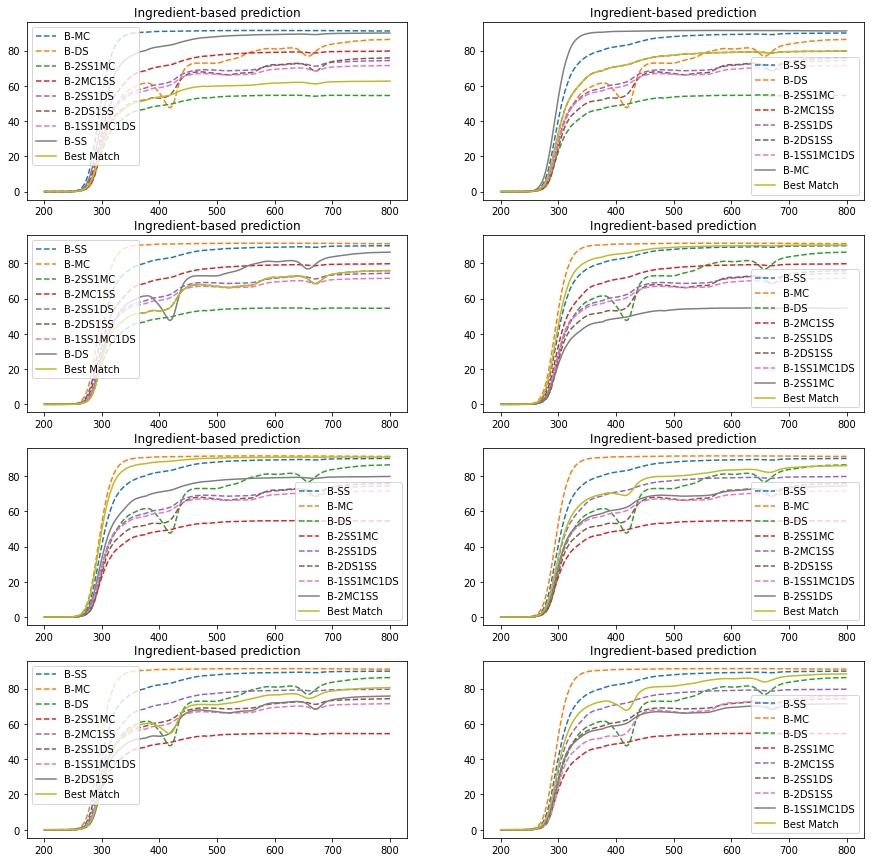

In [ ]:
# Ingredient based prediction
allBioplastics = [BSS, BMC, BDS, B2SS1MC, B2MC1SS, B2SS1DS, B2DS1SS, B1SS1MC1DS]
predictTransmissionNNLS(allBioplastics, 1)

##Plotting for PPT

[<__main__.bioplastic object at 0x7fe8d16cf650>, <__main__.bioplastic object at 0x7fe8d16cfc50>, <__main__.bioplastic object at 0x7fe8d16cffd0>, <__main__.bioplastic object at 0x7fe8d16cff10>, <__main__.bioplastic object at 0x7fe8d16cfa50>, <__main__.bioplastic object at 0x7fe8d1b68c50>, <__main__.bioplastic object at 0x7fe8d1b68a90>]
To Match = B-SS
Ingredient results [Best Match (To Match)]
Sargassum Percentage: 0.02 (0.75)
Cellulose Percentage: 0.80 (0.25)
Dulse Percentage: 0.19 (0.00)
R Squared
Transmittance: 0.99553
Ingredients: -1.99030
 
[<__main__.bioplastic object at 0x7fe8d16cf650>, <__main__.bioplastic object at 0x7fe8d16cfc50>, <__main__.bioplastic object at 0x7fe8d16cffd0>, <__main__.bioplastic object at 0x7fe8d16cff10>, <__main__.bioplastic object at 0x7fe8d16cfa50>, <__main__.bioplastic object at 0x7fe8d1b68c50>, <__main__.bioplastic object at 0x7fe8d1b68a90>]
To Match = B-SS
Ingredient results [Best Match (To Match)]
Sargassum Percentage: 0.49 (0.75)
Cellulose Percentag

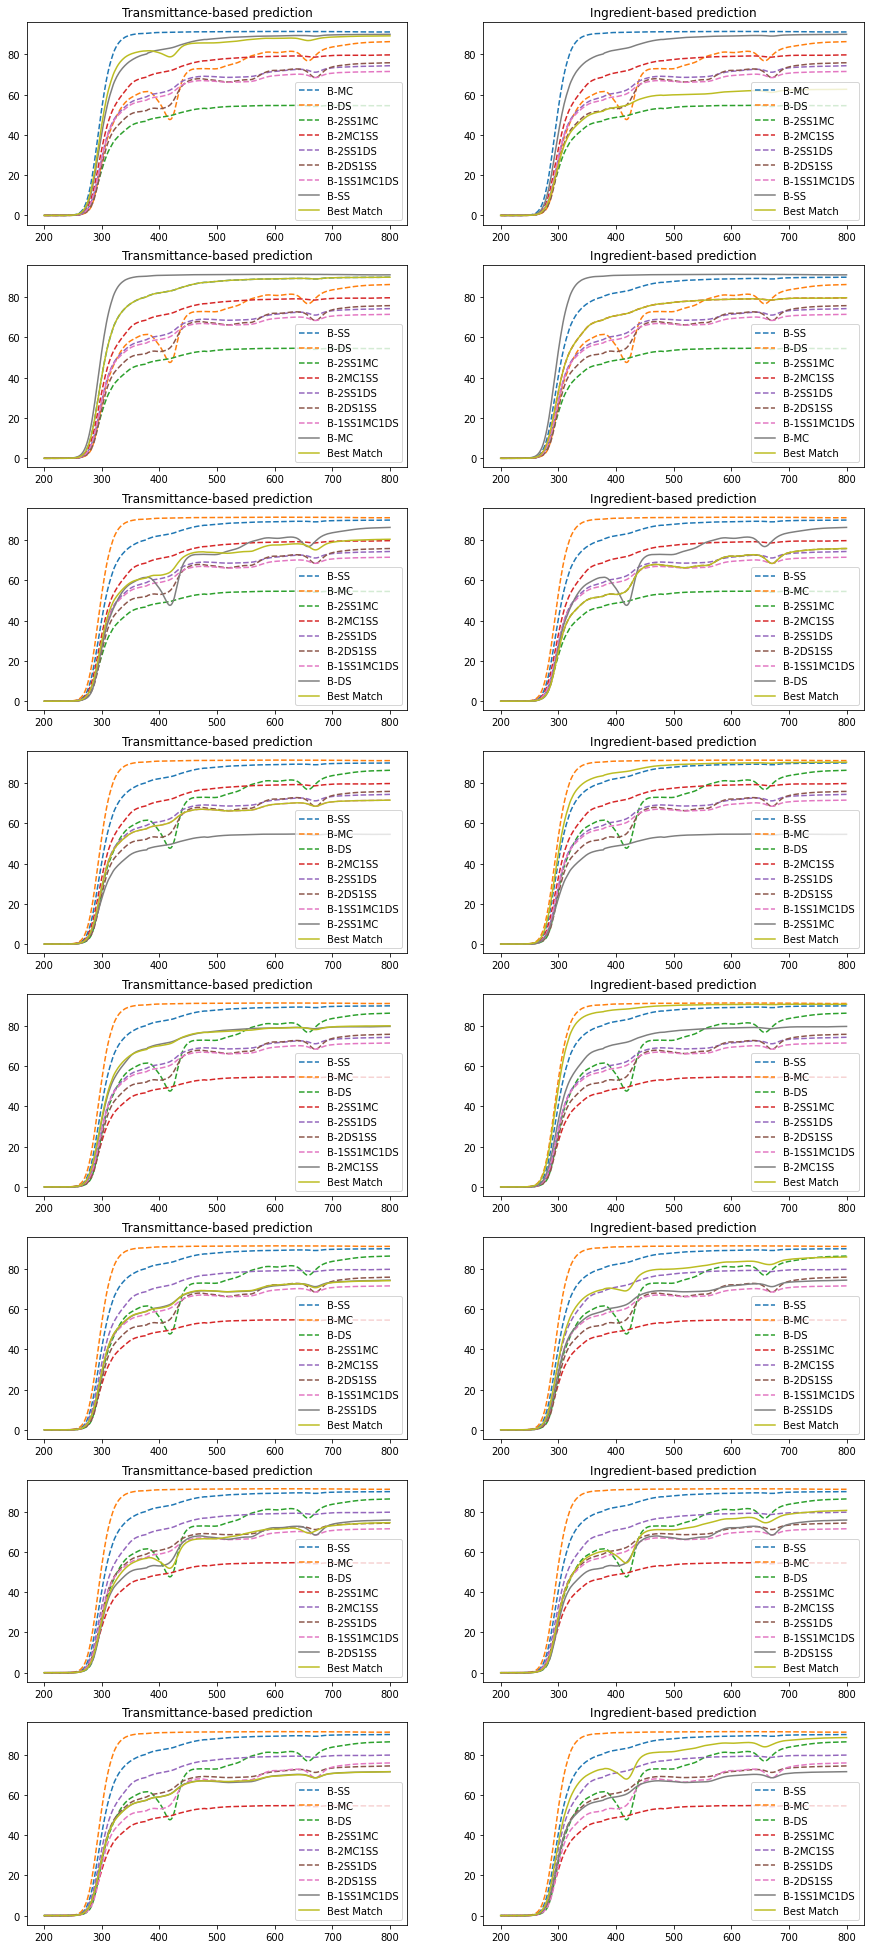

In [ ]:
fig, ((ax1,ax2),(ax3,ax4), (ax5,ax6), (ax7,ax8),(ax9,ax10),(ax11,ax12),(ax13,ax14),(ax15,ax16)) = plt.subplots(8,2, figsize=(15,35))
axs = (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12,ax13,ax14,ax15,ax16)
for i, bioToMatch in enumerate(allBioplastics[:]):
  bioBioplastics = allBioplastics[:i] + allBioplastics[(i+1):]
  predictFromTransmittanceNNLS(bioBioplastics, bioToMatch, axs[2*i])
  predictFromIngredientsNNLS(bioBioplastics, bioToMatch, axs[2*i+1])

# Water absorption prediction

In [ ]:
def predictNNLS_helper(known_x,known_y, unknown_x, unknown_y):
  # predict unknown from known
  big_number = 100000
  known_x = np.hstack((known_x, big_number*np.ones((known_x.shape[0],1))))
  known_y = np.append(known_y, big_number)
  # transpose
  unknown_x = unknown_x.T
  known_x = known_x.T

  # non-negative least squares
  [x,xx] = scipy.optimize.nnls(known_x, known_y)
  
  bestMatch_unknown = matmul(unknown_x, x)
  bestMatch_known = matmul(known_x[:-1,:], x)
  return bestMatch_known, bestMatch_unknown

def predictAbsorptionFromIngredientsNNLShelper(bioplastics, toMatch,type):
  # Input: ingredient ratio Output: absorption
  absorption_x_AvgSTD, absorption_y_AvgSTD, ingredients_x, ingredients_y = absorptionIngredientsXY(toMatch,bioplastics)
  absorption_x = np.vstack((absorption_x_AvgSTD[:,0], absorption_x_AvgSTD[:,2])).T
  absorption_y = np.hstack((absorption_y_AvgSTD[0], absorption_y_AvgSTD[2]))
  if type==0:
    bestMatch_absorption, bestMatch_ingredients = predictNNLS_helper(absorption_x, absorption_y, ingredients_x,ingredients_y)
  if type==1:
    bestMatch_ingredients, bestMatch_absorption = predictNNLS_helper(ingredients_x,ingredients_y, absorption_x, absorption_y)
  
  bestMatch = bioplastic('Best Match', transmission=[0], summary=bestMatch_ingredients, absorption=bestMatch_absorption)

  R2absorption, R2ingredients = printSummaryAbsorption(toMatch, bestMatch)
  return R2absorption, R2ingredients, bestMatch

## Plotting

In [ ]:
def plotPredictedAbsorbance(allBioplastics, bestMatches):
  toMatchIngRatio = zeros_like(allBioplastics)
  toMatchIncWeightAvg = zeros_like(toMatchIngRatio)
  toMatchIncWeightSTD = zeros_like(toMatchIngRatio)
  toMatchSolWeightAvg = zeros_like(toMatchIngRatio)
  toMatchSolWeightSTD = zeros_like(toMatchIngRatio)
  bestMatchIngRatio = zeros_like(toMatchIngRatio)
  bestMatchIncWeightAvg = zeros_like(toMatchIngRatio)
  bestMatchIncWeightSTD = zeros_like(toMatchIngRatio)
  bestMatchSolWeightAvg = zeros_like(toMatchIngRatio)
  bestMatchSolWeightSTD = zeros_like(toMatchIngRatio)
  for i in range(1,len(allBioplastics)):
    toMatch = allBioplastics[i]
    bestMatch = bestMatches[i]
    toMatchIngRatio[i] = toMatch.getIngredientRatio()[0]
    toMatchIncWeightAvg[i] = toMatch.getIncreaseInWeight()[0]
    toMatchIncWeightSTD[i] = toMatch.getIncreaseInWeight()[1]
    toMatchSolWeightAvg[i] = toMatch.getSolubleWeightLost()[0]
    toMatchSolWeightSTD[i] = toMatch.getSolubleWeightLost()[1]

    bestMatchIngRatio[i] = bestMatch.getIngredientRatio()[0]
    bestMatchIncWeightAvg[i] = bestMatch.getIncreaseInWeight()[0]
    bestMatchIncWeightSTD[i] = bestMatch.getIncreaseInWeight()[1]
    bestMatchSolWeightAvg[i] = bestMatch.getSolubleWeightLost()[0]
    bestMatchSolWeightSTD[i] = bestMatch.getSolubleWeightLost()[1]
  fig, [a1, a2] = plt.subplots(2,1, figsize=(9,8))
  fig.subplots_adjust(hspace=.3)
  a1.errorbar(toMatchIngRatio, toMatchIncWeightAvg, toMatchIncWeightSTD, linestyle='None', marker='^', label='Actual Sargassum')
  a1.errorbar(toMatchIngRatio, toMatchIncWeightAvg, toMatchIncWeightSTD, linestyle='None', marker='^', label='Actual Cellulose')
  a1.errorbar(toMatchIngRatio, toMatchIncWeightAvg, toMatchIncWeightSTD, linestyle='None', marker='^', label='Actual Dulse')
  a2.errorbar(toMatchIngRatio, toMatchSolWeightAvg, toMatchSolWeightSTD, linestyle='None', marker='^', label='Actual Sargassum')
  a2.errorbar(toMatchIngRatio, toMatchSolWeightAvg, toMatchSolWeightSTD, linestyle='None', marker='^', label='Actual Cellulose')
  a2.errorbar(toMatchIngRatio, toMatchSolWeightAvg, toMatchSolWeightSTD, linestyle='None', marker='^', label='Actual Dulse')
  a1.errorbar(bestMatchIngRatio, bestMatchIncWeightAvg, bestMatchIncWeightSTD, linestyle='None', marker='^', label='Predict Sargassum')
  a1.errorbar(bestMatchIngRatio, bestMatchIncWeightAvg, bestMatchIncWeightSTD, linestyle='None', marker='^', label='Predict Cellulose')
  a1.errorbar(bestMatchIngRatio, bestMatchIncWeightAvg, bestMatchIncWeightSTD, linestyle='None', marker='^', label='Predict Dulse')
  a2.errorbar(bestMatchIngRatio, bestMatchSolWeightAvg, bestMatchSolWeightSTD, linestyle='None', marker='^', label='Predict Sargassum')
  a2.errorbar(bestMatchIngRatio, bestMatchSolWeightAvg, bestMatchSolWeightSTD, linestyle='None', marker='^', label='Predict Cellulose')
  a2.errorbar(bestMatchIngRatio, bestMatchSolWeightAvg, bestMatchSolWeightSTD, linestyle='None', marker='^', label='Predict Dulse')
  a1.legend()
  a1.set_title('Weight Increase')
  a1.set_xlabel('Material (%)')
  a1.set_ylabel('Weight Increase (%)')
  a2.legend()
  a2.set_title('Soluble Matter Lost')
  a2.set_xlabel('Material (%)')
  a2.set_ylabel('Soluble Matter Lost (%)')

## predictAbsorption(allBioplastics, type=0/1) - Absorption Combination 

In [ ]:
def predictAbsorptionIngredientsNNLS(allBioplastics,type):
  # type = 0 - predict ingredients from absorbance (known: absorbance, unknown: ingredients)
  # type = 1 - predict absorbance from ingredients (known: ingredients, unknown: absorbance)
  R2absorption = zeros(len(allBioplastics))
  R2ingredients = zeros(len(allBioplastics))
  bestMatches = zeros_like(allBioplastics)

  for i, bioToMatch in enumerate(allBioplastics[:]):
    bioBioplastics = allBioplastics[:i] + allBioplastics[(i+1):]
    R2absorption[i], R2ingredients[i], bestMatches[i] = predictAbsorptionFromIngredientsNNLShelper(bioBioplastics, bioToMatch, type)
  print(R2absorption)
  print(R2ingredients)
  print(average(R2absorption[:7]))
  print(average(R2ingredients[:7]))
  #plotPredictedAbsorbance(allBioplastics, bestMatches)

allBioplastics = [BSS, BMC, BDS, B2SS1MC, B2MC1SS, B2SS1DS, B2DS1SS, B1SS1MC1DS]
predictAbsorptionIngredientsNNLS(allBioplastics, 0)

To Match = B-SS
Ingredient results [Predicted (Actual)]
Sargassum Percentage: 0.47 (0.75)
Cellulose Percentage: 0.26 (0.25)
Dulse Percentage: 0.27 (0.00)
Absorption [Predicted (Actual)]
Increase in Weight: 5.36 (-0.50)
Soluble Weight Lost: 54.25 (49.90)
R Squared
Absorption: 0.95807
Ingredients: 0.47749
 
To Match = B-MC
Ingredient results [Predicted (Actual)]
Sargassum Percentage: 0.31 (0.00)
Cellulose Percentage: 0.69 (1.00)
Dulse Percentage: 0.00 (0.00)
Absorption [Predicted (Actual)]
Increase in Weight: 40.46 (35.90)
Soluble Weight Lost: 19.18 (13.10)
R Squared
Absorption: 0.77778
Ingredients: 0.72070
 
To Match = B-DS
Ingredient results [Predicted (Actual)]
Sargassum Percentage: 0.29 (0.00)
Cellulose Percentage: 0.24 (0.27)
Dulse Percentage: 0.47 (0.73)
Absorption [Predicted (Actual)]
Increase in Weight: 12.88 (4.00)
Soluble Weight Lost: 67.74 (74.40)
R Squared
Absorption: 0.95028
Ingredients: 0.43787
 
To Match = B-2SS1MC
Ingredient results [Predicted (Actual)]
Sargassum Percenta

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in long_scalars


# If I combine the transmittance plot for Sargassum, Cellulose, and Dulse, will it match the predicted values?

# Gaussian process regression

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

def GPRFromIngredientsNNLS(bioplastics, toMatch,ax):
  transmittance_x, transmittance_x_real, transmittance_y, ingredients_x, ingredients_y, norms = transmittanceIngredientsXY(toMatch,bioplastics)
  # make sure results add to 1
  big_number = 100000
  ingredients_x = np.hstack((ingredients_x, big_number*np.ones((ingredients_x.shape[0],1))))
  ingredients_y = np.append(ingredients_y, big_number)
  #print(transmittance_x)

  # transpose
  transmittance_x = transmittance_x.T
  #transmittance_x_real = transmittance_x_real.T
  ingredients_x = ingredients_x.T

  kernel = DotProduct() + WhiteKernel()
  gpr = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(ingredients_x, ingredients_y)
  GPR_score = gpr.score(ingredients_x, ingredients_y)
  GPRbestMatch = gpr.predict(toMatch.getIngredientRatio(), return_std=True)

  bestMatch_ingredients = [0,0,0]#matmul(ingredients_x[:-1,:], x)
  bestMatch = bioplastic('Best Match', bestMatch_GPR, bestMatch_ingredients)

  for bio in bioplastics:
    #if norm:
    bio.plotTransmittance(ax,'--', norm=norm)
    #else:
    #  bio.plotTransmittance(ax,'--')
  toMatch.plotTransmittance(ax, norm=norm)
  bestMatch.plotTransmittance(ax,norm=norm)
  ax.legend()
  ax.set_title('Ingredient-based prediction')

In [ ]:
fig, ((ax1,ax2),(ax3,ax4), (ax5,ax6), (ax7,ax8)) = plt.subplots(4,2, figsize=(15,15))
axs = (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8)
for i, bioToMatch in enumerate(allBioplastics[:]):
    bioBioplastics = allBioplastics[:i] + allBioplastics[(i+1):]
    GPRFromIngredientsNNLS(bioBioplastics, bioToMatch, axs[i])


In [ ]:
# Gaussian Process Regression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C


X = np.atleast_2d([1, 3, 5, 6, 7, 8]).T

# Observations
y = f(X).ravel()

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
x = np.atleast_2d(np.linspace(0, 599, 600)).T

# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
disp(x)
plt.figure()
plt.plot(x, f(x), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
#plt.ylim(-10, 20)
plt.legend(loc='upper left')

# ----------------------------------------------------------------------
# now the noisy case
X = np.linspace(0.1, 9.9, 20)
X = np.atleast_2d(X).T

# Observations and noise
#y = f(X).ravel()
#dy = 0.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise

# Instantiate a Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, alpha=dy ** 2,
                              n_restarts_optimizer=10)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()
#plt.plot(x, f(x), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.errorbar(X.ravel(), y, dy, fmt='r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')

plt.show()

#Water Absorption 

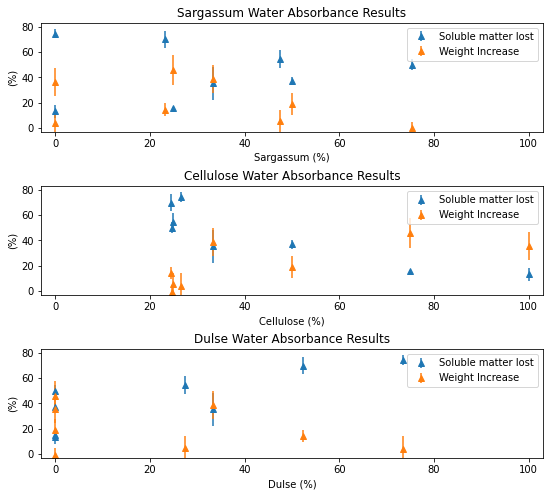

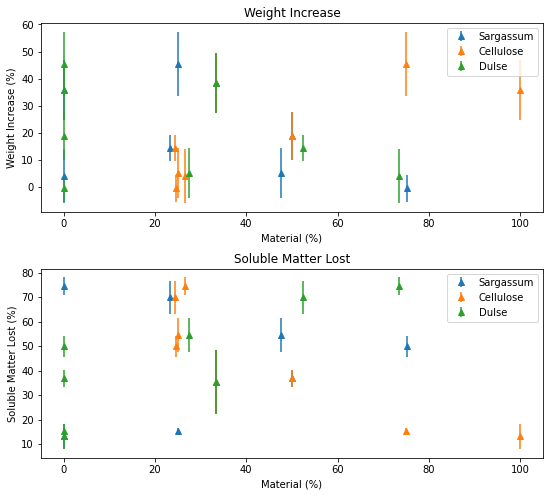

In [ ]:
allBioplastics = [BSS, BMC, BDS, B2SS1MC, B2MC1SS, B2SS1DS, B2DS1SS, B1SS1MC1DS]

def getWaterAbsorptionData(allBioplastics):
  percentSolubleAvg = []
  percentSolubleSTD = []
  percentIncreaseAvg = []
  percentIncreaseSTD = []
  percentSS = []
  percentMC = []
  percentDS = []
  for i, bio in enumerate(allBioplastics[:]):
    solub = bio.getSolubleWeightLost()
    percentSolubleAvg.append(solub[0])
    percentSolubleSTD.append(solub[1])
    incr = bio.getIncreaseInWeight()
    percentIncreaseAvg.append(incr[0])
    percentIncreaseSTD.append(incr[1])
    ingred = [a * 100 for a in bio.getIngredientRatio()]
    percentSS.append(ingred[0])
    percentMC.append(ingred[1])  
    percentDS.append(ingred[2])
  return percentSolubleAvg, percentSolubleSTD, percentIncreaseAvg, percentIncreaseSTD, percentSS, percentMC, percentDS

def plotWaterAbsorbance(allBioplastics):
  percentSolubleAvg, percentSolubleSTD, percentIncreaseAvg, percentIncreaseSTD, percentSS, percentMC, percentDS = getWaterAbsorptionData(allBioplastics)
  fig, [ax1, ax2, ax3] = plt.subplots(3,1, figsize=(9,8))
  fig.subplots_adjust(hspace=.5)
  #ax.plot(percentSS, percentSolubleAvg, linetype, label=self.name)
  ax1.errorbar(percentSS, percentSolubleAvg, percentSolubleSTD, linestyle='None', marker='^', label='Soluble matter lost')
  ax1.errorbar(percentSS, percentIncreaseAvg, percentIncreaseSTD, linestyle='None', marker='^', label='Weight Increase')
  ax1.legend()
  ax1.set_ylabel('(%)')
  ax1.set_xlabel('Sargassum (%)')
  ax1.set_title('Sargassum Water Absorbance Results')
  ax1.set_ybound(-3,83)
  ax1.set_xbound(-3,103)

  ax2.errorbar(percentMC, percentSolubleAvg, percentSolubleSTD, linestyle='None', marker='^', label='Soluble matter lost')
  ax2.errorbar(percentMC, percentIncreaseAvg, percentIncreaseSTD, linestyle='None', marker='^', label='Weight Increase')
  ax2.legend()
  ax2.set_ylabel('(%)')
  ax2.set_xlabel('Cellulose (%)')
  ax2.set_title('Cellulose Water Absorbance Results')
  ax2.set_ybound(-3,83)
  ax2.set_xbound(-3,103)

  ax3.errorbar(percentDS, percentSolubleAvg, percentSolubleSTD, linestyle='None', marker='^', label='Soluble matter lost')
  ax3.errorbar(percentDS, percentIncreaseAvg, percentIncreaseSTD, linestyle='None', marker='^', label='Weight Increase')
  ax3.legend()
  ax3.set_ylabel('(%)')
  ax3.set_xlabel('Dulse (%)')
  ax3.set_title('Dulse Water Absorbance Results')
  ax3.set_ybound(-3,83)
  ax3.set_xbound(-3,103)

  fig, [a1, a2] = plt.subplots(2,1, figsize=(9,8))
  fig.subplots_adjust(hspace=.3)
  a1.errorbar(percentSS, percentIncreaseAvg, percentIncreaseSTD, linestyle='None', marker='^', label='Sargassum')
  a1.errorbar(percentMC, percentIncreaseAvg, percentIncreaseSTD, linestyle='None', marker='^', label='Cellulose')
  a1.errorbar(percentDS, percentIncreaseAvg, percentIncreaseSTD, linestyle='None', marker='^', label='Dulse')
  a1.legend()
  a1.set_title('Weight Increase')
  a1.set_xlabel('Material (%)')
  a1.set_ylabel('Weight Increase (%)')
  
  a2.errorbar(percentSS, percentSolubleAvg, percentSolubleSTD, linestyle='None', marker='^', label='Sargassum')
  a2.errorbar(percentMC, percentSolubleAvg, percentSolubleSTD, linestyle='None', marker='^', label='Cellulose')
  a2.errorbar(percentDS, percentSolubleAvg, percentSolubleSTD, linestyle='None', marker='^', label='Dulse')
  a2.legend()
  a2.set_title('Soluble Matter Lost')
  a2.set_xlabel('Material (%)')
  a2.set_ylabel('Soluble Matter Lost (%)')

plotWaterAbsorbance(allBioplastics)

In [ ]:
)percentSS = []


ingred = BSS.getIngredientRatio()
print(ingred)
percentSS.append(ingred[0])
